<a href="https://colab.research.google.com/github/sayanbanerjee32/paddy_comp_with_jhoward/blob/main/multi_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

# !pip install -Uq 'timm>=0.6.2.dev'
!pip install -Uq pynvml
from fastkaggle import *

In [4]:
# import colab libraries
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_api_auth/kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
from fastai.vision.all import *
set_seed(42)

from fastcore.parallel import *
trn_path = path/'train_images'

100%|██████████| 1.02G/1.02G [00:04<00:00, 273MB/s]


In [8]:
df = pd.read_csv(path/'train.csv', index_col='image_id')
df.head()

,label,variety,age
image_id,,,
100330.jpg,bacterial_leaf_blight,ADT45,45
100365.jpg,bacterial_leaf_blight,ADT45,45
100382.jpg,bacterial_leaf_blight,ADT45,45
100632.jpg,bacterial_leaf_blight,ADT45,45
101918.jpg,bacterial_leaf_blight,ADT45,45


In [9]:
# function get varity from image path
def get_variety(p): return df.loc[p.name, 'variety']

In [10]:
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock,CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y = [parent_label,get_variety],
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
).dataloaders(trn_path)

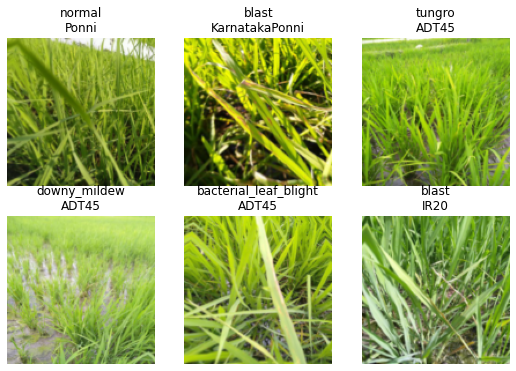

In [11]:
dls.show_batch(max_n=6)

In [12]:
# revised loss and metric function for diese target
def disease_err(inp,disease,variety): return error_rate(inp,disease)
def disease_loss(inp,disease,variety): return F.cross_entropy(inp,disease)

### replicate single target model

In [13]:
arch = 'convnext_small_in22k'
learn = vision_learner(dls, arch, loss_func=disease_loss, metrics=disease_err, n_out=10).to_fp16()
lr = 0.01

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


In [ ]:
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,disease_err,time
0,1.330953,0.785519,0.261893,01:53


epoch,train_loss,valid_loss,disease_err,time
0,0.670292,0.469898,0.145603,01:53
1,0.510557,0.377688,0.118212,01:38


### Now multi-target model

In [ ]:
learn = vision_learner(dls, arch, n_out=20).to_fp16()

In [ ]:
# loss functions for multi target
def disease_loss(inp,disease,variety): return F.cross_entropy(inp[:,:10],disease)
def variety_loss(inp,disease,variety): return F.cross_entropy(inp[:,10:],variety)
def combine_loss(inp,disease,variety): return disease_loss(inp,disease,variety)+variety_loss(inp,disease,variety)

In [ ]:
# error rate for multi target
def disease_err(inp,disease,variety): return error_rate(inp[:,:10],disease)
def variety_err(inp,disease,variety): return error_rate(inp[:,10:],variety)

err_metrics = (disease_err,variety_err)

In [ ]:
all_metrics = err_metrics+(disease_loss,variety_loss)

In [ ]:
learn = vision_learner(dls, arch, loss_func=combine_loss, metrics=all_metrics, n_out=20).to_fp16()

In [ ]:
learn.fine_tune(5, lr)